# 0. Import Libaries + Data

In [1]:
# import pandas as pd
# import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
import matplotlib.dates as mdates

from datetime import datetime
import dateutil.parser
import copy

# from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
# from sklearn.metrics import classification_report,roc_auc_score, make_scorer
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import MinMaxScaler,StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
# from sklearn.base import BaseEstimator, TransformerMixin


# import tensorflow as tf
# from tensorflow.keras import backend as K
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# from keras.regularizers import l1, l2
# from keras.optimizers import Adam

# from sklearn import tree
# from sklearn.base import BaseEstimator
# from sklearn.preprocessing import StandardScaler

# from hypopt import GridSearch
# import keras_tuner as kt

# from keras.models import Sequential
# from keras.layers import Dense, LSTM
# from keras.losses import BinaryCrossentropy

# from optuna import Trial, create_study, create_trial



import warnings
warnings.filterwarnings("ignore")

In [2]:
from model import *
from preprocess import *
from crawling import *

Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.3

Phiên bản Vnai 2.0.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.2

In [3]:
start_time = '2017-12-31'
# start_time = '2023-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

daily_full = VN_Stock_fully_data(start_time, end_time)

In [4]:
# start_time = '2017-12-31'
# end_time = '2025-03-01'

# list_choice = 'VN30'

# hourly_test = VN_Stock_close_data(start_time, end_time, interval = '1H')
# hourly_test

In [5]:
# start_time = '2017-12-31'
# end_time = '2025-03-01'

# list_choice = 'VN30'

# daily_test = VN_Stock_close_data(start_time, end_time)
# daily_test

In [6]:
# plt.plot(30 - daily_test.isna().sum(axis = 1))
# plt.title(f"Số lượng công ty trên {list_choice} có dữ liệu theo thời gian")
# plt.xlabel("Thời gian")
# plt.ylabel("Số lượng công ty")

# 1. Analysis

In [7]:
def describe_data_list(data):
  ''' Hàm mô tả dữ liệu
      INPUT: data_list(list): Một list bao gồm các dataframe
        * Lưu ý: Nếu chỉ sử dụng 1 công ty, chỉ cần truyền vào 1 dataframe dưới dạng list: (VD: [df])
      OUTPUT: các thông tin chung và mô tả các biến số của tất cả dataframe có trong list
  '''
  print(data.name)
  print(data.info())
  print(data.describe())
  print("=========================================")

  return

In [8]:
# plt.figure(figsize = (24, 12))
# plt.tight_layout()
# plt.xticks([])
# plt.yticks([])
# sns.reset_orig()
# plt.suptitle("Khối lượng giao dịch của các công ty trong VN30")
# for x in range(1,31):
#   ax = plt.subplot(5,6, x)
#   ax.plot(daily_full[x-1].index,daily_full[x-1]['volume'])
#   plt.xticks([])
#   plt.title(daily_full[x-1].name)
#   # plt.savefig(daily_full[x].name)

# 2. Cleaning Data

# 3. Feature Engineering

In [9]:
feature = pd.DataFrame(np.empty((0, 21)))
for x in range(0,29):
  temp = feature_engineering(daily_full[x])
  feature.columns = temp.columns
  feature = pd.concat([feature,temp], axis = 0)
  # print(feature.shape)
feature = feature.sort_index()


In [10]:
feature['good_signal'].value_counts()

good_signal
 0.0    40693
 5.0      487
 4.0      440
 3.0      351
-5.0      288
 2.0      277
-4.0      274
-2.0      269
-3.0      229
 1.0        9
-1.0        8
Name: count, dtype: int64

In [11]:
# feature = pd.get_dummies(feature, columns=['Symbol'], drop_first = True)
feature = feature.drop(['Symbol'],axis = 1)
feature

,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC10,ROC15,ROC20,ROC40,ROC60,MACD_1_5,MACD_5_20,MACD_20_60,VWAP,signal_momentum,good_signal
2019-01-04,0.261905,0.25,0.403909,0.333333,0.492348,0.456349,0.006410,-0.044140,-0.014129,-0.044140,-0.084548,-0.087209,-0.033846,-0.158177,-0.088069,-0.143337,-0.156807,7.463786,-0.081871,0.0
2019-01-04,0.309573,0.45,0.350823,0.383333,0.494491,0.503968,-0.002246,-0.024158,0.018140,-0.081481,-0.128758,-0.120712,-0.153248,-0.301637,-0.702280,-2.588527,-3.568456,64.217892,-0.111333,0.0
2019-01-04,0.398764,0.35,0.481981,0.450000,0.450104,0.392857,0.017043,0.041678,0.016372,-0.023840,-0.059499,-0.052437,0.054521,-0.030601,0.804595,-1.075518,-0.298251,86.769034,-0.043132,0.0
2019-01-04,0.222910,0.35,0.311044,0.300000,0.487667,0.444444,0.006390,-0.040609,-0.019710,0.000000,-0.116822,-0.159253,-0.241573,-0.283005,-0.136900,-0.469038,-0.971572,12.548131,-0.141689,0.0
2019-01-04,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.079977,-0.116758,-0.124827,-0.128773,-0.206901,-2.454183,-5.481703,-6.273283,145.110446,-0.128107,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.733333,0.60,0.658031,0.516667,0.530936,0.507937,0.000000,-0.008363,0.000000,0.023428,0.017157,0.092105,0.086387,0.172316,0.044881,0.966369,1.910026,25.642167,0.090670,0.0
2025-02-28,0.500000,0.40,0.463629,0.416667,0.479987,0.408730,0.000000,-0.011193,0.012985,0.031422,0.022990,0.000000,-0.025154,-0.028151,-0.126728,0.596119,-0.749080,69.771874,0.028068,0.0
2025-02-28,0.804511,0.55,0.589873,0.466667,0.538554,0.472222,0.013970,0.005774,0.008102,0.028335,0.092848,0.102532,0.132640,0.088750,0.334135,1.148338,1.134478,45.016000,0.108142,0.0
2025-02-28,0.610619,0.60,0.621429,0.616667,0.542653,0.523810,-0.001305,-0.025478,-0.015444,0.000000,0.021362,0.033784,0.030997,0.153846,-0.287820,0.371402,1.601991,23.668114,0.046512,0.0


In [12]:
# feature.to_csv("feature.csv")

In [13]:
# corr = feature.drop(columns = ['Symbol']).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [14]:
feature

,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC10,ROC15,ROC20,ROC40,ROC60,MACD_1_5,MACD_5_20,MACD_20_60,VWAP,signal_momentum,good_signal
2019-01-04,0.261905,0.25,0.403909,0.333333,0.492348,0.456349,0.006410,-0.044140,-0.014129,-0.044140,-0.084548,-0.087209,-0.033846,-0.158177,-0.088069,-0.143337,-0.156807,7.463786,-0.081871,0.0
2019-01-04,0.309573,0.45,0.350823,0.383333,0.494491,0.503968,-0.002246,-0.024158,0.018140,-0.081481,-0.128758,-0.120712,-0.153248,-0.301637,-0.702280,-2.588527,-3.568456,64.217892,-0.111333,0.0
2019-01-04,0.398764,0.35,0.481981,0.450000,0.450104,0.392857,0.017043,0.041678,0.016372,-0.023840,-0.059499,-0.052437,0.054521,-0.030601,0.804595,-1.075518,-0.298251,86.769034,-0.043132,0.0
2019-01-04,0.222910,0.35,0.311044,0.300000,0.487667,0.444444,0.006390,-0.040609,-0.019710,0.000000,-0.116822,-0.159253,-0.241573,-0.283005,-0.136900,-0.469038,-0.971572,12.548131,-0.141689,0.0
2019-01-04,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.079977,-0.116758,-0.124827,-0.128773,-0.206901,-2.454183,-5.481703,-6.273283,145.110446,-0.128107,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.733333,0.60,0.658031,0.516667,0.530936,0.507937,0.000000,-0.008363,0.000000,0.023428,0.017157,0.092105,0.086387,0.172316,0.044881,0.966369,1.910026,25.642167,0.090670,0.0
2025-02-28,0.500000,0.40,0.463629,0.416667,0.479987,0.408730,0.000000,-0.011193,0.012985,0.031422,0.022990,0.000000,-0.025154,-0.028151,-0.126728,0.596119,-0.749080,69.771874,0.028068,0.0
2025-02-28,0.804511,0.55,0.589873,0.466667,0.538554,0.472222,0.013970,0.005774,0.008102,0.028335,0.092848,0.102532,0.132640,0.088750,0.334135,1.148338,1.134478,45.016000,0.108142,0.0
2025-02-28,0.610619,0.60,0.621429,0.616667,0.542653,0.523810,-0.001305,-0.025478,-0.015444,0.000000,0.021362,0.033784,0.030997,0.153846,-0.287820,0.371402,1.601991,23.668114,0.046512,0.0


In [15]:
def Volatility_scale(train_data, ignore_na=False, adjust = True, com = 60, min_periods=0):

    scaled_data = pd.DataFrame(columns=train_data.columns, dtype=float)
    scaled_data.drop(columns = ['Symbol'], inplace = True)

    for company, group in train_data.groupby('Symbol'):  # Process each company separately
      non_scaled_data = group[['signal_momentum',]]

      # volume_data = group[['MA_volume20','MA_volume60','MA_volume252']]
      volume_data = group[['Volume']]

      temp = group
      temp.drop(columns = ['signal_momentum','Symbol','Volume'], inplace = True)
      # Tính daily volatility (vol)
      temp = temp.ewm(ignore_na=ignore_na,
                            adjust=adjust,
                            com=com,
                            min_periods=min_periods).std(bias = False)

      temp  /= np.sqrt(252)  # scale lại theo 252 ngày active trading

      volume_data = (volume_data - volume_data.rolling(window=60,min_periods = 1).mean()) / volume_data.rolling(window=60, min_periods = 1).std()

      temp = pd.concat([temp, non_scaled_data], axis=1)
      temp = pd.concat([temp, volume_data], axis=1)

      scaled_data = pd.concat([scaled_data,temp], axis = 0)

    return scaled_data

scaler = FunctionTransformer(Volatility_scale)

In [16]:
# def Volatility_scale(train_data, ignore_na=False, adjust = True, com = 60, min_periods=0):

#     scaled_data = pd.DataFrame(columns=train_data.columns, dtype=float)
#     scaled_data.drop(columns = ['Symbol'], inplace = True)

#     for company, group in train_data.groupby('Symbol'):  # Process each company separately
#     #   non_scaled_data = group[['signal_momentum','RSI20','RSI60','RSI252','PSY20','PSY60','PSY252']]

#     #   # volume_data = group[['MA_volume20','MA_volume60','MA_volume252']]
#     #   volume_data = group[['Volume']]

#       temp = group
#       temp.drop(columns = ['Symbol'], inplace = True)
#     #   # Tính daily volatility (vol)
#     #   temp = temp.ewm(ignore_na=ignore_na,
#     #                         adjust=adjust,
#     #                         com=com,
#     #                         min_periods=min_periods).std(bias = False)

#     #   temp  /= np.sqrt(252)  # scale lại theo 252 ngày active trading

#     #   volume_data = (volume_data - volume_data.rolling(window=60,min_periods = 1).mean()) / volume_data.rolling(window=60, min_periods = 1).std()

#     #   temp = pd.concat([temp, non_scaled_data], axis=1)
#     #   temp = pd.concat([temp, volume_data], axis=1)

#       scaled_data = pd.concat([scaled_data,temp], axis = 0)

#     return scaled_data

# scaler = FunctionTransformer(Volatility_scale)

In [17]:
# corr = Volatility_scale(feature).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [18]:
# class TimeSeriesScalerDF(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.previous_max = {}  # Store max per column

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         transformed_df = pd.DataFrame(index=X.index, columns=X.columns)

#         for col in X.columns:
#             col_values = X[col].values.astype(float)
#             running_max = self.previous_max.get(col, col_values[0])  # Keep previous max

#             transformed_col = np.zeros_like(col_values)
#             for i in range(len(col_values)):
#                 if i == 0 and col not in self.previous_max:
#                     transformed_col[i] = col_values[i]  # Keep first value
#                 else:
#                     running_max = max(running_max, col_values[i - 1])
#                     transformed_col[i] = (col_values[i] - running_max) / running_max if running_max != 0 else 0

#             transformed_df[col] = transformed_col
#             self.previous_max[col] = running_max  # Save max for next batch

#         return transformed_df


In [19]:
# for x ,y in trainX.groupby('Symbol'):
#     print(f"Processing {x}")
#     print(y)

In [20]:
class TimeSeriesScalerDF(BaseEstimator, TransformerMixin):
    def __init__(self, list_choice):
        stock = Vnstock().stock(symbol='ACB', source='VCI')
        self.company_column = stock.listing.symbols_by_group(list_choice) # Column name identifying companies
        self.previous_min = {}  # Store cumulative min per (company, column)
        self.previous_max = {}  # Store cumulative max per (company, column)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        transformed_df = pd.DataFrame(columns=X.columns, dtype=float)
        transformed_df.drop(columns = ['Symbol'], inplace = True)
        print(X.groupby(self.company_column))
        for company, group in X.groupby('Symbol'):  # Process each company separately
            temp = pd.DataFrame(index= group.index, columns=X.columns, dtype=float)
            temp.drop(columns = ['Symbol'], inplace = True)
            # print(f"Processing {company}")
            # print(group)
            for col in group.columns:
                if col == 'Symbol':
                    continue  # Skip the company column

                col_values = group[col].astype(float)
                # print(col_values)

                # Retrieve previous min/max for this (company, column) pair
                key = (company, col)
                running_min = self.previous_min.get(key, col_values.iloc[0])
                running_max = self.previous_max.get(key, col_values.iloc[0])

                # Compute cumulative min and max
                cumin_t = np.minimum.accumulate(np.insert(col_values.values, 0, running_min))[1:]
                cumax_t = np.maximum.accumulate(np.insert(col_values.values, 0, running_max))[1:]

                # print([cumin_t,cumax_t])

                # Apply scaling formula
                transformed_col = (col_values - cumin_t) / (cumax_t - cumin_t)
                transformed_col = np.nan_to_num(transformed_col, nan=0.0)  # Handle division by zero

                temp[col] = transformed_col

                # Store the last min and max for future use
                self.previous_min[key] = cumin_t[-1]
                self.previous_max[key] = cumax_t[-1]

            transformed_df = pd.concat([transformed_df,temp], axis = 0)
            transformed_df = transformed_df.sort_index()

        return transformed_df


In [21]:
def prepare_X_y(df):
    ''' Hàm chia X,y từ dữ liệu
          INPUT: df(dataframe): dữ liệu đã được tạo feature
          OUTPUT: X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
    '''
    columns = df.columns.tolist()
    columns.remove('good_signal')
    X = df[columns]
    y = df['good_signal']

    return X, y

def split_train_test(X, y, train_size=0.8):
    ''' Hàm chia tập train, test cho dữ liệu:
          INPUT:
            X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
            train_size: tỉ lệ chia train/test; mặc định là 0.8
          OUTPUT: trainX, testX ,trainY, testY(dataframe): các tập train/test đã được chia ra
    '''
    # Chia tập train/test
    # trainX, testX ,trainY, testY = train_test_split(X, y, train_size=train_size, shuffle=False)

    split_idx = int(len(X) * train_size)  # Compute the split index

    trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
    trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]

    # In ra những thông tin chi tiết về kích cỡ tập train/test; và khoảng thời gian xử lí
    print('TrainX:' + str(trainX.shape) + f". Dữ liệu từ ngày {trainX.index.min().date()} đến {trainX.index.max().date()}")
    print('TrainY:' + str(trainY.shape) + f". Dữ liệu từ ngày {trainY.index.min().date()} đến {trainY.index.max().date()}")
    print('TestX:' + str(testX.shape) + f". Dữ liệu từ ngày {testX.index.min().date()} đến {testX.index.max().date()}")
    print('TestY:' + str(testY.shape) + f". Dữ liệu từ ngày {testY.index.min().date()} đến {testY.index.max().date()}")

    return trainX, testX ,trainY, testY

In [22]:
# def manual_time_series_split(data, n_splits = 5):
#     """Manually splits time series data into train-test sets."""
#     n_samples = len(data)
#     split_size = (n_samples - n_splits) // (n_splits + 1)  # Size of each test set

#     splits = []
#     for i in range(n_splits):
#         train_end = split_size * (i + 1) + i  # Expanding train set
#         test_start = train_end
#         test_end = test_start + split_size

#         train_indices = np.argwhere(data.index <= dateutil.parser.parse(str(data.iloc[[train_end]].index[0]))).flatten().tolist()
#         test_indices = np.argwhere((data.index <= dateutil.parser.parse(str(data.iloc[[test_end]].index[0]))) & (data.index > dateutil.parser.parse(str(data.iloc[[test_start]].index[0])))).flatten().tolist()

#         splits.append((train_indices, test_indices))

#     return splits

In [23]:
# # Scale data before applying PCA
# # Scaled_data = Volatility_scale(trainX)[1:]
# Scaled_data = Volatility_scale(trainX)

# # Use fit and transform method

# # Set the n_components=3
# principal=PCA(n_components=2)
# principal.fit(Scaled_data)
# x=principal.transform(Scaled_data)

# # Check the dimensions of data after PCA
# print(x.shape)

# plt.figure(figsize=(10,10))
# plt.scatter(x[:,0],x[:,1],c=trainY,cmap='plasma')
# plt.xlabel('pc1')
# plt.ylabel('pc2')
# plt.show()



In [24]:
X, y = prepare_X_y(feature)

trainX, testX ,trainY, testY = split_train_test(X, y)
print(trainX)
print(trainY)

TrainX:(34683, 19). Dữ liệu từ ngày 2019-01-04 đến 2023-12-14
TrainY:(34683,). Dữ liệu từ ngày 2019-01-04 đến 2023-12-14
TestX:(8642, 19). Dữ liệu từ ngày 2023-12-15 đến 2025-02-28
TestY:(8642,). Dữ liệu từ ngày 2023-12-15 đến 2025-02-28
               RSI20  PSY20     RSI60     PSY60    RSI252    PSY252      ROC1  \
2019-01-04  0.261905   0.25  0.403909  0.333333  0.492348  0.456349  0.006410   
2019-01-04  0.309573   0.45  0.350823  0.383333  0.494491  0.503968 -0.002246   
2019-01-04  0.398764   0.35  0.481981  0.450000  0.450104  0.392857  0.017043   
2019-01-04  0.222910   0.35  0.311044  0.300000  0.487667  0.444444  0.006390   
2019-01-04  0.123959   0.30  0.319276  0.383333  0.495924  0.456349 -0.010331   
...              ...    ...       ...       ...       ...       ...       ...   
2023-12-14  0.184874   0.15  0.368702  0.366667  0.470431  0.436508  0.000000   
2023-12-14  0.348101   0.40  0.471537  0.450000  0.544418  0.515873  0.008394   
2023-12-14  0.487097   0.50  0.47

In [25]:
# # Scale data before applying PCA
# Scaled_data = TimeSeriesScalerDF().transform(trainX)
# # Scaled_data = trainX

# # Use fit and transform method

# # Set the n_components=2

# principal=PCA(n_components=2)
# principal.fit(Scaled_data)
# x=principal.transform(Scaled_data)

# plt.figure(figsize=(10,10))
# plt.scatter(x[:,0],x[:,1],c=trainY,cmap='plasma')
# plt.xlabel('pc1')
# plt.ylabel('pc2')
# plt.show()


In [26]:
# trainX = pd.DataFrame(np.empty((0,36)))
# testX = pd.DataFrame(np.empty((0,36)))
# trainY = pd.Series()
# testY = pd.Series()
# for x in range(0,30):
#   temp = feature_engineering(daily_full[x])

#   X, y = prepare_X_y(temp)

#   trainX_temp, testX_temp ,trainY_temp, testY_temp = split_train_test(X, y)
#   trainX.columns = trainX_temp.columns
#   trainX = pd.concat([trainX,trainX_temp], axis = 0)
#   testX.columns = testX_temp.columns
#   testX = pd.concat([testX,testX_temp], axis = 0)
#   trainY = pd.concat([trainY,trainY_temp], axis = 0)
#   testY = pd.concat([testY,testY_temp], axis = 0)

#   print([trainX.shape,trainY.shape,testX.shape, testY.shape])

# 4. Model

## Random forest

In [27]:
# # Generate a sample time series dataset
# X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)

# # Manually define test fold indices for a time series split (5 folds)
# n_samples = len(y)
# n_splits = 5
# test_size = n_samples // (n_splits + 1)  # Ensure growing training set
# test_fold = np.full(n_samples, -1)  # Initialize all as training (-1)

# for i in range(n_splits):
#     start_test = (i + 1) * test_size
#     end_test = start_test + test_size
#     test_fold[start_test:end_test] = i  # Assign fold number

# # Create PredefinedSplit
# ps = PredefinedSplit(test_fold)


# split_idx = int(len(X) * train_size)  # Compute the split index

# trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
# trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]


In [28]:
test_model = train_random_forest(trainX,trainY)

# test_model = train_random_forest_optuna(trainX,trainY)

In [29]:
prediction = test_model.predict(trainX)
print(classification_report(trainY, prediction))

              precision    recall  f1-score   support

        -5.0       1.00      1.00      1.00       272
        -4.0       1.00      1.00      1.00       258
        -3.0       1.00      1.00      1.00       223
        -2.0       1.00      1.00      1.00       265
        -1.0       1.00      1.00      1.00         8
         0.0       1.00      1.00      1.00     32207
         1.0       1.00      1.00      1.00         9
         2.0       1.00      1.00      1.00       267
         3.0       1.00      1.00      1.00       325
         4.0       1.00      1.00      1.00       408
         5.0       1.00      1.00      1.00       441

    accuracy                           1.00     34683
   macro avg       1.00      1.00      1.00     34683
weighted avg       1.00      1.00      1.00     34683



In [30]:
prediction = test_model.predict(testX)
prediction.sum()

300.0

In [31]:
prediction = test_model.predict(testX)
print(classification_report(testY, prediction))

              precision    recall  f1-score   support

        -5.0       0.70      0.88      0.78        16
        -4.0       0.71      0.31      0.43        16
        -3.0       1.00      1.00      1.00         6
        -2.0       1.00      0.75      0.86         4
         0.0       1.00      1.00      1.00      8486
         2.0       0.50      0.20      0.29        10
         3.0       0.75      0.92      0.83        26
         4.0       0.59      0.31      0.41        32
         5.0       0.70      0.85      0.76        46

    accuracy                           0.99      8642
   macro avg       0.77      0.69      0.71      8642
weighted avg       0.99      0.99      0.99      8642



In [32]:
# prediction = test_model.predict(trainX)
# prediction *= np.sign(trainX["signal_momentum"])
# print(classification_report(np.sign(trainX["signal_momentum"]) * trainY, prediction))

In [33]:
# prediction = test_model.predict(testX)
# prediction *= np.sign(testX["signal_momentum"])
# print(classification_report(np.sign(testX["signal_momentum"]) * testY, prediction))

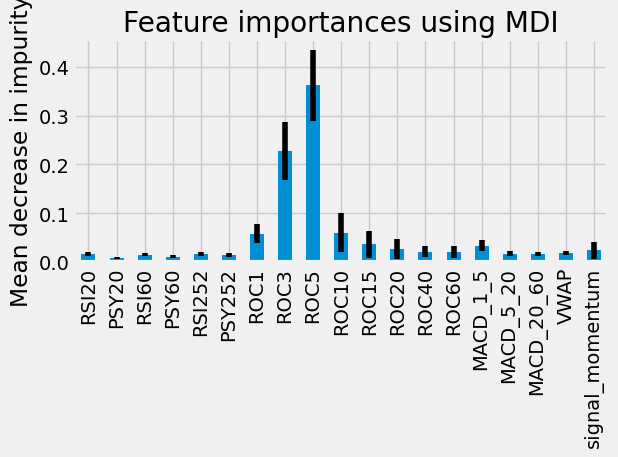

In [34]:
importances = test_model['classifier'].feature_importances_

# feature_names = trainX.drop(columns = ['Symbol']).columns

feature_names = trainX.columns


forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in test_model['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [35]:
# import pickle

# # save the iris classification model as a pickle file
#   model_pkl_file = "random_forest_model_0.5892.pkl"

# with open(model_pkl_file, 'wb') as file:
#     pickle.dump(test_model, file)

# Sharpe Loss

In [36]:
trainX.shape

(34683, 19)

In [37]:
model, history = train_Lasso_supervised(trainX, trainY,1,1, binary = True)
# model, history = train_LSTM_supervised(trainX, trainY,1,binary = True)  

Trial 100 Complete [00h 00m 39s]
loss: 0.20305335521697998

Best loss So Far: 0.20135892927646637
Total elapsed time: 00h 34m 42s
Epoch 1/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.8186
Epoch 2/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3058
Epoch 3/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2785
Epoch 4/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2669
Epoch 5/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2610
Epoch 6/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2538
Epoch 7/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2501
Epoch 8/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2451
Epoch 9/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2531
Epoch 10/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2397
Epoch 11/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2400
Epoch 12/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2355
Epoch 13/100
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

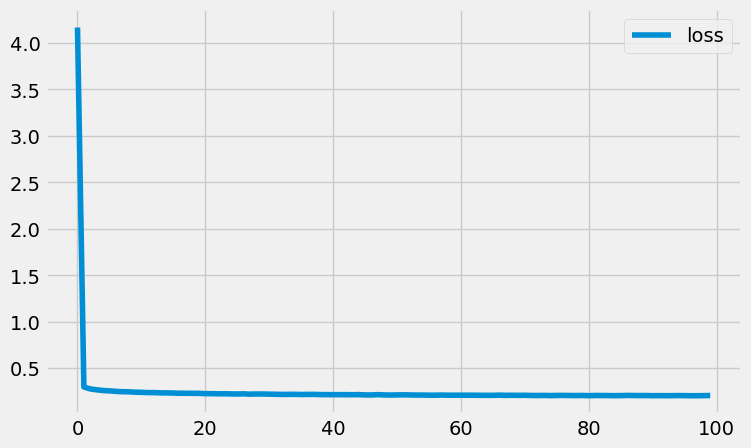

In [38]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [39]:
prediction = test_model.predict(trainX)
print(classification_report( trainY, prediction))

              precision    recall  f1-score   support

        -5.0       1.00      1.00      1.00       272
        -4.0       1.00      1.00      1.00       258
        -3.0       1.00      1.00      1.00       223
        -2.0       1.00      1.00      1.00       265
        -1.0       1.00      1.00      1.00         8
         0.0       1.00      1.00      1.00     32207
         1.0       1.00      1.00      1.00         9
         2.0       1.00      1.00      1.00       267
         3.0       1.00      1.00      1.00       325
         4.0       1.00      1.00      1.00       408
         5.0       1.00      1.00      1.00       441

    accuracy                           1.00     34683
   macro avg       1.00      1.00      1.00     34683
weighted avg       1.00      1.00      1.00     34683



In [40]:
test_model.predict(testX[0:1])

array([0.])

In [41]:
prediction

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
prediction = test_model.predict(testX)
print(classification_report( testY, prediction))

              precision    recall  f1-score   support

        -5.0       0.70      0.88      0.78        16
        -4.0       0.71      0.31      0.43        16
        -3.0       1.00      1.00      1.00         6
        -2.0       1.00      0.75      0.86         4
         0.0       1.00      1.00      1.00      8486
         2.0       0.50      0.20      0.29        10
         3.0       0.75      0.92      0.83        26
         4.0       0.59      0.31      0.41        32
         5.0       0.70      0.85      0.76        46

    accuracy                           0.99      8642
   macro avg       0.77      0.69      0.71      8642
weighted avg       0.99      0.99      0.99      8642



In [43]:
np.unique(prediction, return_counts= True)

(array([-5., -4., -3., -2.,  0.,  2.,  3.,  4.,  5.]),
 array([  20,    7,    6,    3, 8497,    4,   32,   17,   56], dtype=int64))

In [44]:
model, history = train_MLP_supervised(trainX, trainY,1,1, binary = True)

Trial 100 Complete [00h 00m 14s]
loss: 0.4140402376651764

Best loss So Far: 0.1733626425266266
Total elapsed time: 00h 36m 35s
Epoch 1/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9551
Epoch 1: loss improved from inf to 0.50007, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7633
Epoch 2/100
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2829 
Epoch 2: loss improved from 0.50007 to 0.26974, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2783
Epoch 3/100
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2519 
Epoch 3: loss improved from 0.26974 to 0.24218, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2495
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2361
Epoch 4: loss improved from 0.24218 to 0.23719, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.ke

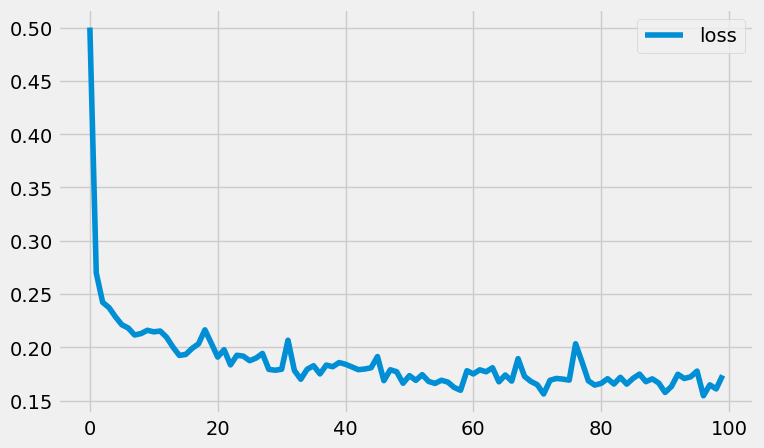

In [45]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [46]:
prediction = test_model.predict(trainX)
print(classification_report(trainY, prediction))

              precision    recall  f1-score   support

        -5.0       1.00      1.00      1.00       272
        -4.0       1.00      1.00      1.00       258
        -3.0       1.00      1.00      1.00       223
        -2.0       1.00      1.00      1.00       265
        -1.0       1.00      1.00      1.00         8
         0.0       1.00      1.00      1.00     32207
         1.0       1.00      1.00      1.00         9
         2.0       1.00      1.00      1.00       267
         3.0       1.00      1.00      1.00       325
         4.0       1.00      1.00      1.00       408
         5.0       1.00      1.00      1.00       441

    accuracy                           1.00     34683
   macro avg       1.00      1.00      1.00     34683
weighted avg       1.00      1.00      1.00     34683



In [47]:
prediction = test_model.predict(testX)
print(classification_report(testY, prediction))

              precision    recall  f1-score   support

        -5.0       0.70      0.88      0.78        16
        -4.0       0.71      0.31      0.43        16
        -3.0       1.00      1.00      1.00         6
        -2.0       1.00      0.75      0.86         4
         0.0       1.00      1.00      1.00      8486
         2.0       0.50      0.20      0.29        10
         3.0       0.75      0.92      0.83        26
         4.0       0.59      0.31      0.41        32
         5.0       0.70      0.85      0.76        46

    accuracy                           0.99      8642
   macro avg       0.77      0.69      0.71      8642
weighted avg       0.99      0.99      0.99      8642



In [48]:
np.unique(prediction, return_counts= True)

(array([-5., -4., -3., -2.,  0.,  2.,  3.,  4.,  5.]),
 array([  20,    7,    6,    3, 8497,    4,   32,   17,   56], dtype=int64))